In [11]:
pip install opencv-python mtcnn numpy

### Thu thập ảnh bằng webcam

In [ ]:
import cv2
import os
import numpy as np
from mtcnn import MTCNN
from datetime import datetime

# --- Cấu hình ---
person_name = "person_01"  
output_dir = f"data/{person_name}"
os.makedirs(output_dir, exist_ok=True)

# --- Khởi tạo ---
cap = cv2.VideoCapture(0)  # Webcam mặc định
detector = MTCNN()
count = 0
max_images = 50  # Số lượng ảnh muốn lưu

print("[INFO] Bắt đầu thu thập ảnh. Nhấn 'q' để thoát.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Phát hiện khuôn mặt
    faces = detector.detect_faces(frame)
    for face in faces:
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        face_img = frame[y:y+h, x:x+w]

        # Resize khuôn mặt về cùng kích thước
        face_img = cv2.resize(face_img, (160, 160))

        # Lưu ảnh
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S%f")
        file_path = os.path.join(output_dir, f"{person_name}_{timestamp}.jpg")
        cv2.imwrite(file_path, face_img)
        count += 1

        # Vẽ khung trên webcam
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Hiển thị
    cv2.imshow("Webcam - Press q to quit", frame)

    # Thoát khi nhấn 'q' hoặc đủ ảnh
    if cv2.waitKey(1) & 0xFF == ord('q') or count >= max_images:
        break

print(f"[INFO] Đã thu thập {count} ảnh tại: {output_dir}")

cap.release()
cv2.destroyAllWindows()


### Thu thập ảnh bằng video

In [ ]:
import cv2
import os
from mtcnn import MTCNN
from datetime import datetime

# --- Cấu hình ---
video_path = "E:/face-detec/data/video/Angela_Merkel.mp4"     
output_dir = "data/train/Angela_Merkel"
person_label = "Angela_Merkel"         
os.makedirs(output_dir, exist_ok=True)

# --- Khởi tạo ---
detector = MTCNN()
cap = cv2.VideoCapture(video_path)
frame_count = 0
saved_count = 0
save_interval = 5  # Mỗi 5 frame mới lưu 1 ảnh (tránh trùng nhiều ảnh giống nhau)

print("[INFO] Đang xử lý video...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % save_interval != 0:
        continue

    faces = detector.detect_faces(frame)
    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        face_img = frame[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (160, 160))

        # Tạo tên file ảnh
        filename = f"{person_label}_{saved_count}.jpg"
        cv2.imwrite(os.path.join(output_dir, filename), face_img)
        saved_count += 1

        # Vẽ khung (tùy chọn)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Hiển thị frame (tuỳ chọn)
    cv2.imshow("Processing", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

print(f"[INFO] Đã lưu {saved_count} khuôn mặt vào: {output_dir}")
cap.release()
cv2.destroyAllWindows()


[INFO] Đang xử lý video...
[INFO] Đã lưu 270 khuôn mặt vào: data/train/Angela_Merkel


### Chia tập dữ liệu để train

In [18]:
import os
import shutil
import random

SOURCE_DIR = "data/train"               # Thư mục gốc chứa toàn bộ ảnh
DEST_DIR = "dataset"              # Thư mục chứa tập train/val sau chia
SPLIT_RATIO = 0.8                 # 80% train, 20% validation

# Tạo thư mục dataset/train và dataset/val
for subset in ["train", "val"]:
    for person in os.listdir(SOURCE_DIR):
        os.makedirs(os.path.join(DEST_DIR, subset, person), exist_ok=True)

# Chia ảnh
for person in os.listdir(SOURCE_DIR):
    person_path = os.path.join(SOURCE_DIR, person)
    images = os.listdir(person_path)
    random.shuffle(images)

    split_idx = int(len(images) * SPLIT_RATIO)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    for img_name in train_imgs:
        src = os.path.join(person_path, img_name)
        dst = os.path.join(DEST_DIR, "train", person, img_name)
        shutil.copyfile(src, dst)

    for img_name in val_imgs:
        src = os.path.join(person_path, img_name)
        dst = os.path.join(DEST_DIR, "val", person, img_name)
        shutil.copyfile(src, dst)

print("Đã chia tập dữ liệu thành train/val.")


Đã chia tập dữ liệu thành train/val.


In [8]:
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [9]:
IMG_SIZE = 160  # tương thích với kích thước ảnh đầu vào cho FaceNet, bạn có thể chọn 128 cũng được
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train",
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/val",
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)


Found 2009 files belonging to 7 classes.
Found 1002 files belonging to 7 classes.


In [10]:
IMG_SIZE = 160
num_classes = len(train_ds.class_names)

data_augmentation = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)), 
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

model = models.Sequential([
    data_augmentation,  

    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,663 (432.28 KB)

 Trainable params: 110,663 (432.28 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 0.2332 - loss: 1.8509 - val_accuracy: 0.5579 - val_loss: 1.2764
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.5035 - loss: 1.2442 - val_accuracy: 0.6327 - val_loss: 0.7949
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.6684 - loss: 0.8010 - val_accuracy: 0.7904 - val_loss: 0.4724
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.8046 - loss: 0.4861 - val_accuracy: 0.8992 - val_loss: 0.2932
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.8781 - loss: 0.3198 - val_accuracy: 0.9052 - val_loss: 0.1812
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.9175 - loss: 0.1994 - val_accuracy: 0.9481 - val_loss: 0.1524
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy: 0.9298 - loss: 0.1656 - val_accuracy: 0.9780 - val_loss: 0.1066
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.9169 - loss: 0.2156 - val_accu

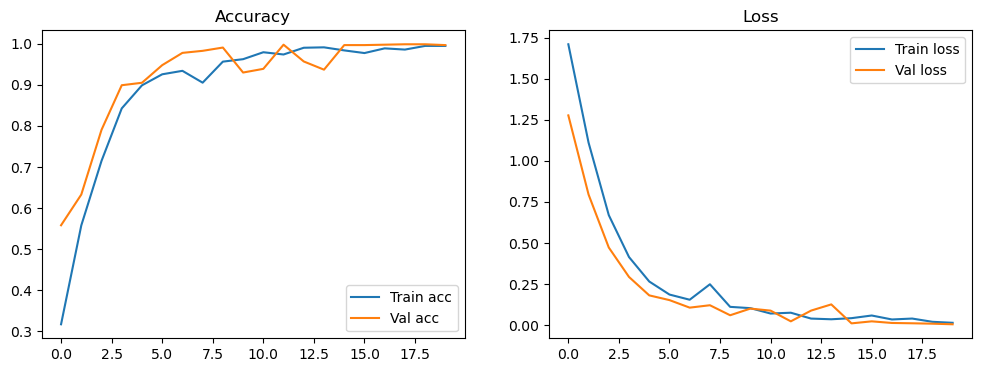

In [12]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title('Loss')

plt.show() 


### Confusion Matrix (ma trận nhầm lẫn)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


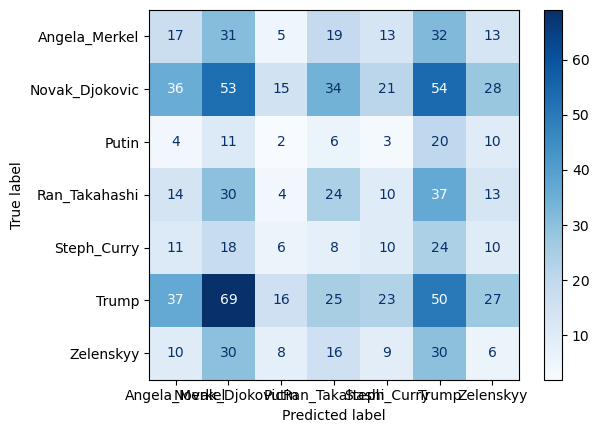

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Chuyển one-hot sang label index
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)  # <--- dòng này sửa lỗi

# Gọi confusion_matrix như bình thường
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
disp.plot(cmap='Blues')



In [20]:
import cv2
import numpy as np

IMG_SIZE = 160  # cùng kích thước như khi huấn luyện

def preprocess(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=0)


In [21]:
model.save("face_cnn_model.keras")  # hoặc .h5 nếu bạn thích


In [ ]:

# Load mô hình đã huấn luyện
model = load_model("E:/face-detec/face_cnn_model.keras")

# Danh sách tên lớp tương ứng với output của mô hình
class_names = ['Trump', 'Zelenskyy', 'Ran_Takahashi',
               'Angela_Merkel', 'Novak_Djokovic', 'Steph_Curry', 'Putin']

# Ngưỡng xác suất tối thiểu để chấp nhận kết quả
threshold = 0.75

# Hàm tiền xử lý khuôn mặt (chuẩn hóa đầu vào)
def preprocess_face(face_img, target_size=(160, 160)):
    try:
        face_resized = cv2.resize(face_img, target_size)
        face_array = face_resized.astype("float32") / 255.0
        return np.expand_dims(face_array, axis=0)
    except:
        return None

# Khởi tạo video input/output
cap = cv2.VideoCapture("E:/face-detec/Trump_test.mp4")
output = cv2.VideoWriter('E:/face-detec/output',
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         20,
                         (int(cap.get(3)), int(cap.get(4))))

# Dùng HaarCascade để phát hiện khuôn mặt
face_cascade = cv2.CascadeClassifier(r"E:/face-detec/haarcascade_frontalface_default.xml")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Phát hiện khuôn mặt
    faces = face_cascade.detectMultiScale(frame, 1.3, 5)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        input_face = preprocess_face(face)

        if input_face is None:
            continue  # bỏ qua nếu lỗi resize hoặc ảnh không hợp lệ

        # Dự đoán
        preds = model.predict(input_face, verbose=0)
        class_id = np.argmax(preds)
        confidence = np.max(preds)

        # Xác định tên
        if confidence < threshold:
            name = f"Unknown ({confidence:.2f})"
        else:
            name = f"{class_names[class_id]} ({confidence:.2f})"

        # Vẽ khung và ghi tên
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, name, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Ghi vào video output và hiển thị
    output.write(frame)
    cv2.imshow('Face Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Giải phóng tài nguyên
cap.release()
output.release()
cv2.destroyAllWindows()
